# 'Drive for dough , putt for show': Distance vs scoring on the PGA Tour pre, during, and post Tiger Woods boom
&emsp;A data anaylsis tutorial presented through Tiger Woods  
&emsp;By: Austin Brady

<img src="2008_US_Open.jpg" width = "650" align="left">

# Table of Contents  
&emsp;**0.** Introduction  
&emsp;**1.** Data Collection/Processing   
&emsp;**2.** Exploratory Analysis and Data Visualization  
&emsp;**3.** Analysis, hypothesis testing, & ML  
&emsp;**4.** Conclusions

# 0. Introduction
Some say golf is a game of luck. While this may be true for the weekend player hacking it around his local municipal course, the players on the PGA Tour are a different beast. They bomb drives down the fairway with pinpoint accuracy and have beautiful short games to match. This combination of power and finesse was brought on by none other than Tiger Woods. He was a different animal, unlike what anyone had seen before in golf. He dominated year after year leaving everyone else scrambling to stay within sight of him. While it is obvious that Tiger hit it far and put up low scores, the question remains: What effect did this have on the driving distances on the pga tour and did an increase in distance lead to a decrease in the scoring averages? 

# 1. Data Collection/Processing

This is the first stage of the data lifecycle. This stage consists of gathering data from whatever source best suits your data science project. Some of these sources are websites, publicly available datasets, and APIs (more on these later). This information normally comes in a few standards forms (we will only talk about three of these forms):  
&emsp;**1. CSV Files:** CSV stands for comma separated values and it is exactly what is sounds like. The data will come in a format where each attribute (column) is separated by a comma and each observation (row) is separated by a newline. For more information, folow this link, https://www.howtogeek.com/348960/what-is-a-csv-file-and-how-do-i-open-it/. While we won't be retreiving our data from CVS files, we will be storing it in them for easier subsequent access.  
&emsp;**2. JSON Files:** JSON is another standard data format where there are two basic data types you will have to deal with (not including strings, integers, booleans, and null). These two formats are an object, called a JSON object, and an array. A JSON object is a key-value pair where the key is a some string representing a defining characteristic for whatever the value is. An array, on the other hand, functions as a container for a user to store certain values that are related in some way. For example, if a teacher were to store their student's names in a JSON object, it may look like this, {"students":["John","Suzy",...]}, where the ... is the rest of array containing the other names. For more information on JSON, follow this link, https://www.copterlabs.com/json-what-it-is-how-it-works-how-to-use-it/  
&emsp;**3. HTML (this tutorial):** Many times, the data we gather may need to be extracted from an HTML table on a webpage. The structure this data is presented in is not always as uniform as the forms listed above, but HTML parsing libraries such as BeautifulSoup make the extracting process hassle-free.

**Libraries needed for data collection/processing stage:**    
&emsp;**1. requests:** Used to send and recieve GET requests for different web pages on the PGA Tour website  
&emsp;**2. BeautifulSoup:** Used to parse the html retrieved by the GET request for specific tags such as tables  
&emsp;**3. Pandas:** Used to create data sturctures to organize data for ease of analysis (DataFrames, Series, etc.)  
&emsp;**4. Numpy:** Used to performm operations on arrays, such as concatenating two arrays together.

In [2]:
# libraries for this stage
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

After importing the libraries, we must set a few things up beforehand. There are a few basic URL formats we need. The first is the basic format of links to extract a specific category for a statistic we are interested in. Each category holds a veriable amount of statistics, which themselves holds multiple statistics (screenshots of the webpages will be included below for clarity). The second url format we need is for once we find the id of the table we are looking for. This will allow us to query a specific statistic for a specific year and retrieve all of the atrributes available in that statistic.

In [161]:
pga_page_url = "http://www.pgatour.com"
basic_stat_url_format = "http://www.pgatour.com/stats/stat.%s.%d.html" # url format to retrieve specific tables
basic_category_url = "http://www.pgatour.com/stats/categories.%s.html" # url format where table is
categories = ['ROTT_INQ','RMNY_INQ','RSCR_INQ'] # url categories
pga_tour_stats_dict = {}
stat_ids = []
categories_i_care_about = ['DRIVING DISTANCE', 'SCORING AVERAGE', 'OFFICIAL MONEY'] # tables we will need

<img src="categories.jpg" width="800">

In [162]:
for category in categories:
    spec_category_url = basic_category_url % category #iterate over categories and send into url from above
    r = requests.get(spec_category_url) #get html from page
    soup = BeautifulSoup(r.content,'html.parser') #pass into beautiful soup so we can easily parse html
    for table in soup.find_all("div", class_="table-content"):
        # find all hrefs that contain links to needed tables and add the id of that table to list for later use
        for link in table.find_all("a"):
            if link.text.upper() in categories_i_care_about and link['href'].split('.')[1] not in stat_ids:
                stat_ids.append(link['href'].split('.')[1])

<img src="stats_table.jpg" width="800">

In [ ]:
overalldf = pd.DataFrame([])
for year in range(1980,2019): #iterate from 1980 to 2018
    yeardf = pd.DataFrame([])
    for identifier in stat_ids: #iterate over ids found from previous cell's code
        #pass year and id into url that links directly to a sspecific stat page ("categories-i-care-about")
        spec_stat_url = basic_stat_url_format % (identifier,year)
        r = requests.get(spec_stat_url)
        soup = BeautifulSoup(r.content,'html.parser')
        table = soup.find('table',class_='table-styled') #find the table of data from the html
        df = pd.read_html(str(table))[0] #extract the table from the array BeautifulSoup put it into
        df = df.drop(columns=['RANK LAST WEEK']) #drop rank last week column from every table found
        if 'EVENTS' in df.columns: #drop events if it is one of the columns
            df = df.drop(columns=['EVENTS'])
        if 'ROUNDS' in df.columns: #drop rounds if it is one of the columns
            df = df.drop(columns=['ROUNDS'])
        i = 0
        for cols in df.columns: #remove letter T (ties) from ranking and cast new value as integer
            if 'RANK' in cols:
                df.iloc[:,i] = df.iloc[:,i].astype(str)
                df.iloc[:,i] = df.iloc[:,i].replace({'T': ''}, regex=True).astype(int)
            i+=1
        for stat in soup.find_all('meta'): #retrieve the name of the stat we're looking at
            if stat['content'].split(' ')[0] == 'Stat':
                stat_name = ' '.join(stat['content'].split(' ')[2:]).upper()
                #change rank this week to more descriptive name for each table we've found
                if stat_name != 'OFFICIAL WORLD GOLF RANKING':
                    df = df.rename(columns = {'RANK THIS WEEK':stat_name+' RANKING'}).astype(str)
                else:
                    df = df.rename(columns = {'RANK THIS WEEK':stat_name}).astype(str)
                #merge the stats from one table onto the stats from the prior for loop iteration
                if yeardf.empty:
                    yeardf = df
                else:
                    yeardf = pd.merge(yeardf,df,how='outer',on='PLAYER NAME')
                break
    #add a column for the year of all statistics we just found
    yeardf['year'] = year
    #build up our overall dataframe that contains all years together
    if overalldf.empty:
        overalldf = yeardf
    else:
        overalldf = pd.merge(overalldf,yeardf,how='outer')
#export the data to a csv for quicker data retrieval (gathering data from 1980-2018 is not quick)
overalldf.to_csv('overall_data.csv',index=False)

In [3]:
#read the data back in from the stored csv
overalldf = pd.read_csv('overall_data.csv')
#drop the extra columns we don't need
overalldf = overalldf.drop(columns=['TOTAL STROKES','TOTAL ADJUSTMENT','TOTAL ROUNDS','YTD VICTORIES'])
#change the name of certain columns to eliminate ambiguity
overalldf = overalldf.rename(columns = {'AVG.':'AVG DISTANCE','AVG':'SCORING AVERAGE'})
overalldf.head() #display the first 5 rows of our new dataframe

,DRIVING DISTANCE RANKING,PLAYER NAME,AVG DISTANCE,TOTAL DISTANCE,TOTAL DRIVES,OFFICIAL MONEY RANKING,MONEY,SCORING AVERAGE RANKING,SCORING AVERAGE,year
0,1.0,Dan Pohl,274.3,51839.0,189.0,44.0,105008,40.0,71.71,1980
1,2.0,Buddy Gardner,272.9,58138.0,213.0,104.0,30907,89.0,72.31,1980
2,3.0,Fuzzy Zoeller,271.5,43167.0,159.0,46.0,95531,33.0,71.56,1980
3,4.0,Joe Hager,270.4,38932.0,144.0,119.0,25394,94.0,72.33,1980
4,4.0,Tommy Valentine,270.4,39745.0,147.0,93.0,36331,88.0,72.30,1980


# 2. Exploratory Analysis and Data Visualization

Below, we are going to poke around to get a feel for that data and see what conclusions the data could present to us for future sections. We will do this through graphs, summary statistics, and trends we may spot in the data. *An important note in this tutorial is that we define a boom as a period of sudden, rapid shift in some aspect. The boom here being distance and the culture shift spurred on by Tiger Woods.*

**Libraries needed for exploratory analysis and data visualization stage:**  
&emsp;**1. Matplotlib:** Used for the vast amount of plotting functionalities and types of plots it yields.

In [4]:
# We will use a histogram, scatter plots , and a line plot for this section.
import matplotlib.pyplot as plt

The first thing we will explore is the distributions of player's average driving distances over a few key years to see what trends we may notice. These years are 1980 (beginning of the dataset), 1995 (a year before Tiger Woods joined the PGA tour), 2005 (midway through Tiger's career), and 2018 (last season). We will use a histogram for this. A histogram is a form of a bar chart that groups data into different bins to examine the distribution of a dataset without worrying about having a lot of data. You may find these links useful to learn about histograms in general and in python:  
https://www.mathsisfun.com/data/histograms.html (general idea)  
https://realpython.com/python-histograms/ (in python)

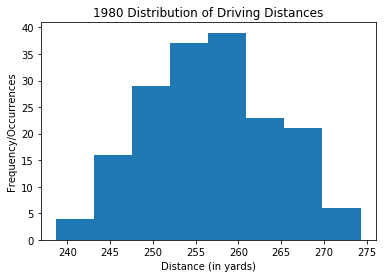

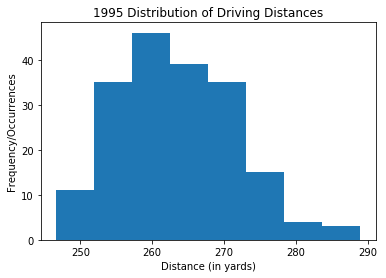

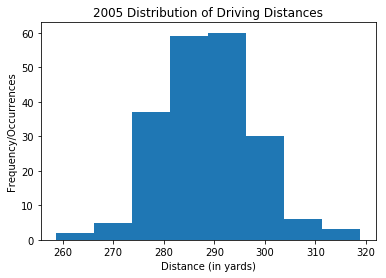

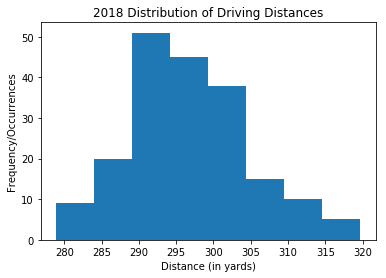

<Figure size 432x288 with 0 Axes>

In [7]:
#drop rows without an average driving distance because histogram can't take NaN values
subdf = overalldf.dropna(subset=['AVG DISTANCE'])
#Make a histogram for the specific years with 8 bins each, give a title, and label the axes
for year in [1980,1995,2005,2018]:
    plt.hist(subdf[subdf['year'] == year]['AVG DISTANCE'],bins=8)
    plt.title('%d Distribution of Driving Distances' % year)
    plt.xlabel('Distance (in yards)')
    plt.ylabel('Frequency/Occurrences')
    plt.figure()

The main takeaway from this is the difference in the mode of the distribution between the first two years and the last two. The mode in 1980 was around 257.5 yards and 15 years later in 1995, it had only increase by about 2.5 yards to 260 yards. In the first 10 years of Tiger's career, the mode then went from 260 yards all the way up to 290 yards. The mode in this time period increased nearly 12 times that of the increase between 1980 and 1995. This is astounding not only because of the rapid growth, but also due to the fact that it occurred in 5 years less than it took the mode to move 2.5 yards total from 1980 t 1995. The data has seemed to level off since 2005 after the initial Tiger boom, but that 10 year growth is astounding. The last thing to notice is pre and post Tiger boom, the data appears to be more skewed towards longer drives than in 2005. What this could mean is that less of an emphasis was placed on distance in the years leading up to and the years following the Tiger boom, causing naturally long hitters to skew the distribution. This article gives a good look into how long hitters are no longer the outliers, but rather the norm: https://www.washingtonpost.com/news/fancy-stats/wp/2017/01/27/tiger-woods-has-lost-one-big-competitive-edge-that-made-him-great/?noredirect=on&utm_term=.b1ffe90cf22b

Next, we will look at scatter plots of scoring average vs driving distance for each player in the dataset for the years 1980, 1995, 2002 (one of Tiger's best years), 2008 (the last year Tiger won a major), and 2018. We split 2005 from the last plot into 2002 and 2008 because it gave a better indicator of the PGA tour distribution at two different points while Tiger was still playing well. From this plot we should be able to determine what kind of trend, if any exist between average distance and scoring average. If all of our points tend to form a line, we can see a linear trend and same for something such as a logarithmic trend. For more information on scatterplots in geenral and in python, check out these resources:  
https://www.mathsisfun.com/data/scatter-xy-plots.html (general idea)  
https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html (in python)

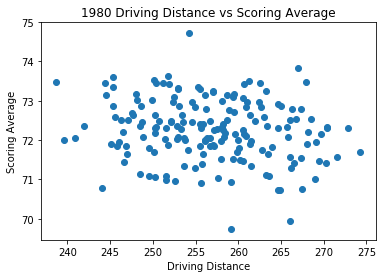

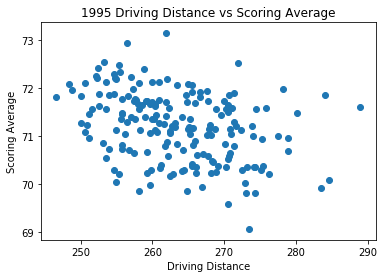

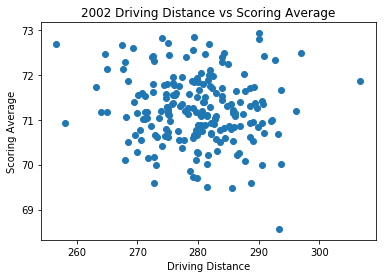

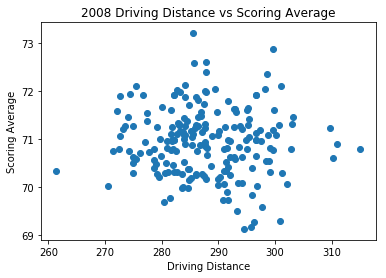

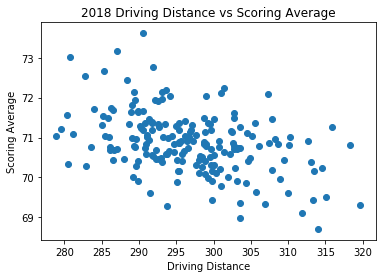

<Figure size 432x288 with 0 Axes>

In [153]:
#don't have to worry about NaN points because scatterplot will just ignore them
for year in [1980,1995,2002,2008,2018]:
    #create new plot subset of dataframe where year column is equal to year from for loop
    subdf = overalldf[overalldf['year'] == year]
    #plot the subset of the dataframe, give a title, and set axis labels
    plt.scatter(x='AVG DISTANCE',y='SCORING AVERAGE',data=subdf)
    plt.title("%d Driving Distance vs Scoring Average" % year)
    plt.xlabel('Driving Distance')
    plt.ylabel('Scoring Average')
    plt.figure()

This provides an interesting outloook on the effect of distance with respect to a player's scoring average. It is easy to spot a slight negative linear trend in each chart other than the ones for 2002, when Tiger was at his prime, and 2008, the yar he won his last US Open and right before he had his knee surgery. This trend could possibly mean that distance is a better indicator of scoring average in the years excluding when Tiger was at his best. This will be something to keep in mind for further analysis.

Next, we need to look at the median scoring average per year to see what the trend actually look like and determine if it could be substantial. To do this, we will take the median of the scoring average column from the DataFrame since median is more robust of a measure than mean (robust meaning resitant to the effects of outliers).

Text(0,0.5,'Median Scoring average (strokes per round)')

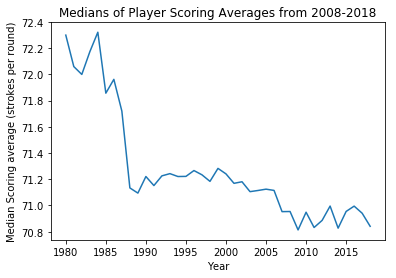

In [196]:
#take the median scoring average from each year and plot in a line plot
years = np.arange(1980,2019)
scoring_average = []
for year in years:
    #append median scoring oaverage for that year onto a list for plotting
    scoring_average.append(overalldf[overalldf['year'] == year]['SCORING AVERAGE'].median())
plt.plot(years, scoring_average)
#set title and axis labels
plt.title('Medians of Player Scoring Averages from 2008-2018')
plt.xlabel('Year')
plt.ylabel('Median Scoring average (strokes per round)')

Now this is a shocking discovery. While I expected the scoring average to decrease over time, the drastic drop around 1987 was unexpected. It wasn't a fluke either as the median stroke average over all players has stayed around or below the 1987 value since then. After doing some research, there are two likely possibilities for this. In the early 1980s, square grooves were designed by a man named Karsten Solheim, the founder of the golf brand PING. Square grooves essentially allowed a "grippier" surface for the golf ball to interact with, producing more spin on the greens, and therefore more control of the ball. The other highly likely explanation was the popularization of metal fairway woods. Prior to the 1980s most players used fairway woods made of a material called persimmon, which was a wood like surface that while it was an improvement over ealier technology, left much to be desired in terms of the distance it yielded. In the early 1980s , players started to pick up on the fact that metal fairway woods would allow them to hit the ball further and, in effect, shorten the golf course. This comes back to the main topic here, distance. You can read more about both of these inovations and the debate that still exists around them here: https://www.golf.com/tour-and-news/usga-finally-makes-call-against-square-grooves and here: https://golf-info-guide.com/golf-equipment-news/the-advent-of-the-metal-driver/.

Lastly, we will standardize the average distance for each player per year. This will allow us to compare the change in the distribtuions of player distances over time. From there we can examine the range of standardized values and see if any outliers stand out. A standardized value, such as a z-score just allows us to take data from separate time period, locations, etc and compare them directly. The standard format, for z-scores specifically, is (actual value-mean)/standard deviation. This will tell us how far above or below a data point is from the mean with respect to everyone else. They basically allow us to normalize values ad put them on a normal curve. If this is confusing, no worries. As before, here are a few helpful links.  
https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/ (z-scores)    
https://www.mathsisfun.com/data/standard-normal-distribution.html (normal bell curve)

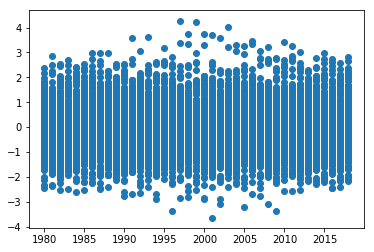

In [8]:
years = np.arange(1980,2019)
distances = []
#produce a standardized meaure for distance for every row of the dataframe
for year in years:
    #using extend instead of append since the result after np.divide will be an array
    #extend will "unpack" the array and append onto distances
    distances.extend(np.divide((overalldf[overalldf['year'] == year]['AVG DISTANCE']-
                                     overalldf[overalldf['year'] == year]['AVG DISTANCE'].mean()),
                                       overalldf[overalldf['year'] == year]['AVG DISTANCE'].std()))
overalldf['STANDARDIZED DISTANCES'] = distances
plt.scatter(x = 'year',y = 'STANDARDIZED DISTANCES',data=overalldf)

The observation here is much more slight than those of the last two. The main thing to notice here is  the absence of outliers on the extreme sides of the time range. Around 1980 there were almost no outliers and the range was fairly compact, but around the time Tiger Woods joined the tour (1996), you have an explosion on both sides of the distribution each year. You have a good bit of players breaking the mold and hitting the ball way further than their peers, as well as a few hitting way shorter than their peers. My initial reaction is to attribute this to a culture shock when Tiger came out on tour. He had power no one had ever seen before and it took 15-20 years for the range to compact back to that of 1980. As the next generation of golfers grew up, they grew an affinity to distance because that's what players like Tiger had. More background on this culture shock Tiger presented can be found here: https://www.golfdigest.com/story/what-golf-looked-like-before-tiger-woods-turned-pro-and-changed-the-game-forever

# 3. Analysis, hypothesis testing, & ML

Now we go onto the analysis, hypothesis testing, and machine learning stage. This is the stage where we use data to back up our intuitions from the prior stage. We have come up with some good assumptions and hypotheses in the last section and now must put them to the test to see if they hold up.

**Libraries needed for data analysis, hypothesis testing, & ML stage:**    
&emsp;**1. math:** Used for access to square root function.  
&emsp;**2. statsmodel:** Used to recieve test statsitic and p-value for least squares  
&emsp;**3. sci-kitlearn:** Used for machine learning capabilities such as modeling, coefficient of determination (explained in this section), and predictions.  

In [5]:
#libraries for this portion
import math # for square root function
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # split data to train the model then test model

Our focus of this tutorial is on the overall change that Tiger Wood's power had on the PGA tour, so we will test a few assumptions. The first is that the decrease in scoring over time is couldn't happen with time alone. To do this, we will use the statsmodels library along with scipy to conduct a hypothesis test on whether this holds. Based on the rhetoric nowadays, we would assume the further a player hits the ball, the lower their scoring average. Therefore, our **null hypothesis is:** The decrease in scoring is due to an increase in distance over time.

In [137]:
X = overalldf[['AVG DISTANCE']].fillna(overalldf['AVG DISTANCE'].median())
y = overalldf['SCORING AVERAGE'].fillna(overalldf['SCORING AVERAGE'].median())
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        SCORING AVERAGE   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     1961.
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:22:51   Log-Likelihood:                -10944.
No. Observations:               11309   AIC:                         2.189e+04
Df Residuals:                   11307   BIC:                         2.191e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           77.0651      0.131    586.100      0.000      76.807      77.323
AVG DISTANCE    -0.0212      0.000    -44.280      0.000      -0.022      -0.020
==============================================================================
Omnibus:                     1010.772   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3615.961
Skew:                           0.418   Prob(JB):                         0.00
Kurtosis:                       5.641   Cond. No.                     6.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can conclude from the above summary statistics that the effect of distance on scoring average is negligible as our p-value is lower than our significance level of 0.05. Therefore, we reject the null hypothesis and state that the decrease in scoring is not due to an increase in distance.

We can cement this determination through the use of the scikit-learn library. Scikit-learn is an analysis library often used in machine learning applications. It will allow us to build a model and see how that model predicts scoring average based on the distance we pass in as a feature (a value to predict off of).

In [156]:
X = overalldf[['AVG DISTANCE']].fillna(overalldf['AVG DISTANCE'].median())
y = overalldf['SCORING AVERAGE'].fillna(overalldf['SCORING AVERAGE'].median())
X_train, X_test, y_train, y_test = train_test_split(X, y) 
reg = LinearRegression()
reg.fit(X_train, y_train)
print("Based on the weights found from the model, a player's scoring average goes down " +
      "%s for every yard of distance they gain." % reg.coef_[0])

Based on the weights found from the model, a player's scoring average goes down -0.02018901864853756 for every yard of distance they gain.


Can we trust the reliability of this conclusion?  Scikit-learn allows us to lookk into this further as it provides you with fairly standard statistics such as the coefficient of determination (r squared value), which tells you how well the data is fitted to the linear regression line built by the model. This information gives us somewhat of a grasp of what the correlation looks like, but it doesn't tell the whole picture. If we want a hard statistic to tell us if there is a correlation and how strong it is, then we must take the square root of the coefficient of determination to get the correlation coefficient (also known as Pearson's correlation coefficient).

In [157]:
math.sqrt(reg.score(X,y))

0.3839885718381882

Correlation coefficients can vary between -1 and 1. A value around -1 implies a strong, negative correlation, a value of 1 implies a strong positive correlation, and a value close to 0 impllies no correlation. The value found in the last cell aligns with what we predicted by looking at the data. A correlation coefficient of 0.38 means the correlation between driving distance and scoring average is weak to moderate. This value can also be determined from OLS above, but it made more sense to split the two analyses up as to test one thing at a time and build evidence for or against our hypothesis. To determine the accuracy of everything we have found so far, we can plot predictions vs actual from the model based on test data (data that has not been seen by the model yet).

Text(0.5,0,'Predicted scoring average')

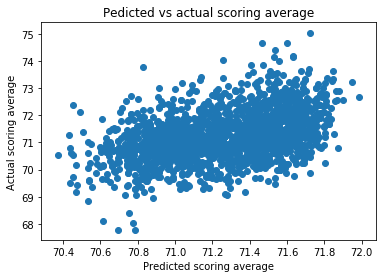

In [158]:
plt.scatter(reg.predict(X_test),y_test)
plt.title('Pedicted vs actual scoring average')
plt.ylabel('Actual scoring average')
plt.xlabel('Predicted scoring average')

Based on the weak to moderate correlation we found of 0.38, it is not surprising that the model has a tough time making accurate predictions from the test data. So I would be hesitant to say that the weight used by the model has any true significance. While it may be what the model used, the lack of a strong correlation and the fact that we rejected our null hypothesis means that weight holds no true meaning in our analysis.

Next we will look at how the predictions change depending on whether we are in the Tiger boom or not. We will define this consistent with the prior analysis. The Tiger boom will be defined as 1996 through 2008.

We will provide the code for before/post Tiger boom and during the boom then compare them.

Correlation coefficient: 0.430160370968609


Text(0.5,0,'Predicted scoring average')

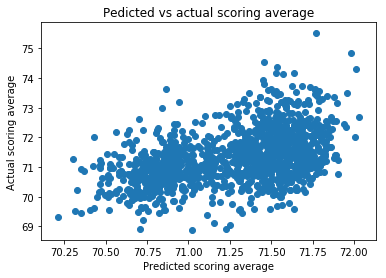

In [192]:
# Pre/post boom
subdf1 = overalldf[overalldf['year'].isin(range(1980,1996))]
subdf2 = overalldf[overalldf['year'].isin(range(2009,2019))]
subdf = pd.merge(subdf1,subdf2,how='outer')
X = subdf[['AVG DISTANCE']].fillna(subdf['AVG DISTANCE'].median())
y = subdf['SCORING AVERAGE'].fillna(subdf['SCORING AVERAGE'].median())
X_train, X_test, y_train, y_test = train_test_split(X, y) 
reg = LinearRegression()
reg.fit(X_train, y_train)
print("Correlation coefficient: " + str(math.sqrt(reg.score(X,y))))
plt.scatter(reg.predict(X_test),y_test)
plt.title('Pedicted vs actual scoring average')
plt.ylabel('Actual scoring average')
plt.xlabel('Predicted scoring average')

Correlation coefficient: 0.16846187554830244


Text(0.5,0,'Predicted scoring average')

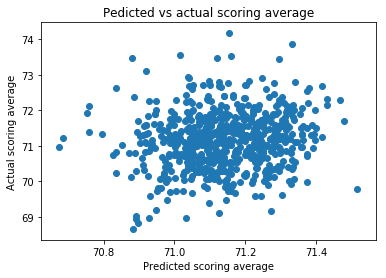

In [194]:
# During boom
subdf = overalldf[overalldf['year'].isin(range(1996,2009))]
X = subdf[['AVG DISTANCE']].fillna(subdf['AVG DISTANCE'].median())
y = subdf['SCORING AVERAGE'].fillna(subdf['SCORING AVERAGE'].median())
X_train, X_test, y_train, y_test = train_test_split(X, y) 
reg = LinearRegression()
reg.fit(X_train, y_train)
print("Correlation coefficient: " + str(math.sqrt(reg.score(X,y))))
plt.scatter(reg.predict(X_test),y_test)
plt.title('Pedicted vs actual scoring average')
plt.ylabel('Actual scoring average')
plt.xlabel('Predicted scoring average')

As you can see, the period during the Tiger boom had the effect of driving the corrleation down slightly. This means that surprisingly, there was a higher correlation between driving distance and scoring average when Tiger was not playing/at his best. Even though Tiger was said to jumpstart the game how it's played now, that is not completely supported by the data. If anything, Tiger disrupted the consistency in the data the showed a moderate correlation between driving distance and scoring average. 

If we provide our model with some contex, it should be able to more accurately predict a player's scoring average. The context we will provide is the player's scoring average ranking for the year in which the respective driving distance was measured. This should yield a convincing correlation as the model is no longer extrapolating without comparison.

Correlation coefficient: 0.8868589272376204


Text(0.5,0,'Predicted scoring average')

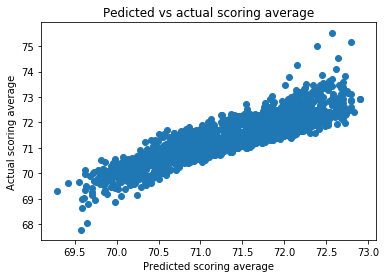

In [195]:
X = overalldf[['AVG DISTANCE','SCORING AVERAGE RANKING']].dropna()
y = overalldf['SCORING AVERAGE'].dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y) 
reg = LinearRegression()
reg.fit(X_train, y_train)
print("Correlation coefficient: " + str(math.sqrt(reg.score(X,y))))
plt.scatter(reg.predict(X_test),y_test)
plt.title('Pedicted vs actual scoring average')
plt.ylabel('Actual scoring average')
plt.xlabel('Predicted scoring average')

Unsurprisingly, we see a much greater correlation between the features and scoring average when the model is given some context. Pearson's correlation coefficient came out as 0.88 this time around(classified as a very strong correlation). This makes sense as the model has been fed a direct relationship between a player's distance and their scoring average in terms of their peers that year. This reaffirms that distance, without context, is not necessarily the greatest indicator of a player's scoring average. Without context, driving distance is just one metric in a pool of many to predict a player's performance.

# 4. Conclusions

Our results gathered from both our hypothesis test and our linear regression model determine that we cannot really determine scoring average solely given a players driving distance and the year in which that distance was measured. We would need context as to how that distance relates to their scoring average. We do know that determining this relationship was even tougher during the Tiger boom as he completely disrupted any correlation that may have existed in the past and flipped the game of golf on it's head. Even though our model did not work well at predicting scoring average, this knowledge is extremely valid. A lot of the rhetoric thrown around by the mainstream golf media focuses around the "long ball making the game easier", but as we can see this is not true. A golfer must still have a well rounded game to perform well as his peers are likely hitting the ball just as far as he is. In conclusion, while driving distances have increase over time, spurred on by Tiger Woods, it has not changed the difficulty it takes to win on the PGA tour. Player's are hitting the ball further than ever, but so are their peers, leading to a negligible effect on success solely due to added distance.